In [3]:
from __future__ import print_function, division

import os
import time
import copy
import numpy as np
import matplotlib.pyplot as plt


import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.optim import lr_scheduler
import torchvision
from torchvision import datasets, models, transforms
from torchsummary import summary
from torchmetrics.classification import Accuracy
from sklearn.metrics import confusion_matrix
import plotly.graph_objs as go

import sys
sys.path.append('../')

from modules.helpers import *
from modules.datasets import *
from modules.train_utils import train_model
from modules.dataloaders import *
from modules.test_utils import test_model

### Initialize wandb and load model

In [4]:
path = "/n/home12/ramith/FYP/bacteria-classification/results/ARP - Resnet 181645133220.7868116/latest_model_epoch-8.pth"
saved = torch.load(path)
cfg   = saved['cfg']

In [5]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

n_c = cfg['n_classes']

class_names = [x for x in range(0, n_c)]

if(n_c == 21):
    class_names = ['Acinetobacter','B subtilis','E. coli K12','S. aureus','E. coli (CCUG17620)','E. coli (NCTC13441)','E. coli (A2-39)','K. pneumoniae (A2-23)','S. aureus (CCUG35600)','E. coli (101)','E. coli (102)','E. coli (104)','K. pneumoniae (210)','K. pneumoniae (211)','K. pneumoniae (212)','K. pneumoniae (240)','Acinetobacter K12-21','Acinetobacter K48-42','Acinetobacter K55-13','Acinetobacter K57-06','Acinetobacter K71-71']
elif(n_c == 5):
    class_names = ['Acinetobacter', 'B. subtilis', 'E. coli', 'K. pneumoniae', 'S. aureus']


In [6]:
cfg

{'learning_rate': 0.01,
 'epochs': 15,
 'pretrained_resnet': True,
 'img_size': 224,
 'n_classes': 2,
 'label_type': 'antibiotic_resistant',
 'balanced_mode': False,
 'expand_channels': True,
 'dataset_sizes': {'train': 375424, 'val': 48544, 'test': 48768}}

In [7]:
model_ft = models.resnet18(pretrained=cfg['pretrained_resnet'])

num_ftrs = model_ft.fc.in_features

model_ft.fc = nn.Linear(num_ftrs, n_c)

model_ft = model_ft.to(device)

In [8]:
model = model_ft
model.load_state_dict(saved['state_dict']);
model.eval();

### Initialize Class Specific Dataloaders

In [9]:
data_dir = '/n/holyscratch01/wadduwage_lab/D2NN_QPM_classification/datasets/bacteria/'

In [10]:
dataloaders = {}

N = 63
_, _, _, _ =  get_bacteria_dataloaders(cfg['img_size'], N , 10, label_type = cfg['label_type'], balanced_mode = False, expand_channels = cfg['expand_channels'])

dataset_sizes = {'test':0}

for i in range(0, 21):
    print("=====")
    dataloaders[str(i)], count =  get_bacteria_eval_dataloaders(cfg['img_size'], N , 10, label_type = cfg['label_type'] ,expand_channels = cfg['expand_channels'], isolate_class = i)

    dataset_sizes['test'] += count['test']

Dataset type train label type: antibiotic_resistant -> Loaded 375443 images
Dataset type val label type: antibiotic_resistant -> Loaded 48562 images
Dataset type test label type: antibiotic_resistant -> Loaded 48790 images
=====
Dataset type test; dataloader will have label type: antibiotic_resistant -> All files = 48790
Loaded 1561 images only from class 0
=====
Dataset type test; dataloader will have label type: antibiotic_resistant -> All files = 48790
Loaded 1404 images only from class 1
=====
Dataset type test; dataloader will have label type: antibiotic_resistant -> All files = 48790
Loaded 1668 images only from class 2
=====
Dataset type test; dataloader will have label type: antibiotic_resistant -> All files = 48790
Loaded 1937 images only from class 3
=====
Dataset type test; dataloader will have label type: antibiotic_resistant -> All files = 48790
Loaded 3114 images only from class 4
=====
Dataset type test; dataloader will have label type: antibiotic_resistant -> All files 

In [68]:
# dataloaders = {}

# N = 63
# _, _, _, dataset_sizes =  get_bacteria_dataloaders(cfg['img_size'], N , 10, label_type = cfg['label_type'], balanced_mode = False, expand_channels = cfg['expand_channels'])


# for i in range(0, cfg['n_classes']):
#     print("=====")
#     dataloaders[str(i)], _ =  get_bacteria_eval_dataloaders(cfg['img_size'], N , 10, label_type = cfg['label_type'] ,expand_channels = cfg['expand_channels'], isolate_class = i)


In [69]:
# dataset_sizes['test'] = dataset_sizes['test']/N

In [70]:
dataset_sizes['test']

765

In [71]:
# for inputs, labels in dataloaders["1"]:
#     print(".", end = '')

#     inputs = inputs.to(device,dtype=torch.float)
#     labels = labels.to(device)

#     outputs = model(inputs)
#     _, preds = torch.max(outputs, 1)
    
#     print(preds)
#     print(torch.mode(preds,0)[0])
#     print(torch.mode(labels,0)[0])
    
#     break

In [11]:
criterion = nn.CrossEntropyLoss()

In [12]:
dataset_sizes

{'test': 765}

In [74]:
from modules.test_utils import test_model_in_groups

In [75]:
test_model_in_groups(model_ft, [dataloaders, dataset_sizes, class_names] , criterion, n_classes = cfg['n_classes'] , device = device, cfg = cfg)

starting group testing..
 dataloader has 2 classes to be evaluated
New class eval - 0
New class eval - 1
New class eval - 2
New class eval - 3
New class eval - 4
New class eval - 5
New class eval - 6
New class eval - 7
New class eval - 8
New class eval - 9
New class eval - 10
New class eval - 11
New class eval - 12
New class eval - 13
New class eval - 14
New class eval - 15
New class eval - 16
New class eval - 17
New class eval - 18
New class eval - 19
New class eval - 20
test Loss: 16.4650 Acc: 0.9961
[0.9801324605941772, 1.0]

testing complete in 1m 29s
Test Acc: 0.996078


[[148, 0], [3, 614]]

In [76]:
# for inputs, labels in dataloaders[str(0)]: #take a batch of data from each class
#     print(".", end = '')

#     inputs = inputs.to(device,dtype=torch.float)
#     labels = labels.to(device)

#     outputs = model(inputs)
#     _, preds = torch.max(outputs, 1)
#     loss = criterion(outputs, labels)

#     preds = torch.mode(preds, 0)[0]
#     preds = torch.reshape(preds, (-1,))
    
#     labels = torch.mode(labels, 0)[0]
#     labels = torch.reshape(labels, (-1,))
#     print(preds)
#     print(labels)
#     break

In [45]:
# g = torch.Tensor(1)

### Occlusion Sensitivity Analysis 

In [63]:
from captum.attr import Occlusion
from captum.attr import visualization as viz

In [76]:
model  = model.to('cpu')
occlusion = Occlusion(model)


In [78]:
h = iter(dataloaders['0'])
input_img = next(h)[0][0].unsqueeze(0)

input_img = input_img.to('cpu', dtype=torch.float)

plt.imshow(input_img[0].T[:,:,0])
plt.colorbar()

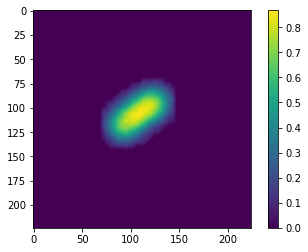

In [92]:
# torch.sum(input_img[:,:,0]==input_img[:,:,1])

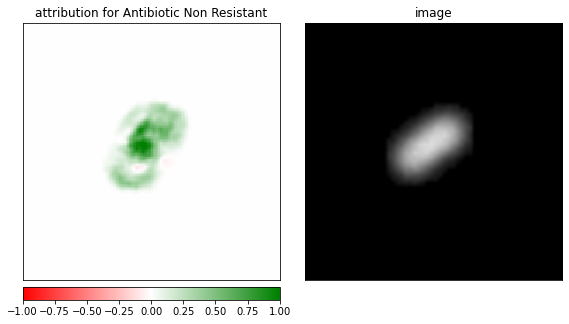

In [112]:
strides = (3, 3, 3)               # smaller = more fine-grained attribution but slower
target=0,                         # Antibiotic resistant
sliding_window_shapes=(3, 5, 5)  # choose size enough to change object appearance
baselines = 0                     # values to occlude the image with. 0 corresponds to gray

attribution_non_res = occlusion.attribute(input_img,
                                       strides = strides,
                                       target=target,
                                       sliding_window_shapes=sliding_window_shapes,
                                       baselines=baselines)

img = input_img[0].T.cpu().numpy()

attribution_non_res = np.transpose(attribution_non_res.squeeze().cpu().detach().numpy(), (1,2,0))

vis_types = ["heat_map", "original_image"]
vis_signs = ["all", "all"] # "positive", "negative", or "all" to show both
# positive attribution indicates that the presence of the area increases the prediction score
# negative attribution indicates distractor areas whose absence increases the score

_ = viz.visualize_image_attr_multiple(attribution_non_res,
                                      img,
                                      vis_types,
                                      vis_signs,
                                      ["attribution for Antibiotic Non Resistant", "image"],
                                      show_colorbar = True
                                     )



### Resistant class

class = tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1])


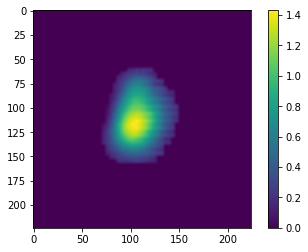

In [123]:
h = iter(dataloaders['10'])

data =  next(h)

input_img = data[0][0].unsqueeze(0)

print(f"class = {data[1]}")
input_img = input_img.to('cpu', dtype=torch.float)

plt.imshow(input_img[0].T[:,:,0])
plt.colorbar()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


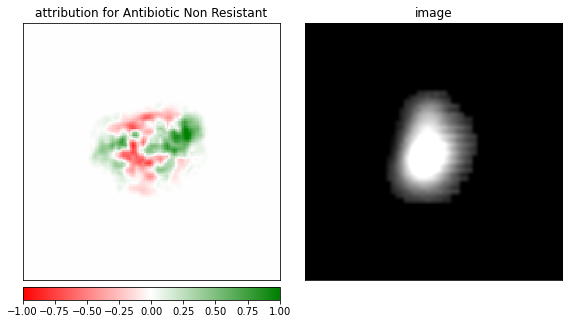

In [125]:
strides = (3, 3, 3)               # smaller = more fine-grained attribution but slower
target=1,                         # Antibiotic resistant
sliding_window_shapes=(3, 5, 5)  # choose size enough to change object appearance
baselines = 0                     # values to occlude the image with. 0 corresponds to gray

attribution_non_res = occlusion.attribute(input_img,
                                       strides = strides,
                                       target=target,
                                       sliding_window_shapes=sliding_window_shapes,
                                       baselines=baselines)

img = input_img[0].T.cpu().numpy()

attribution_non_res = np.transpose(attribution_non_res.squeeze().cpu().detach().numpy(), (1,2,0))

vis_types = ["heat_map", "original_image"]
vis_signs = ["all", "all"] # "positive", "negative", or "all" to show both
# positive attribution indicates that the presence of the area increases the prediction score
# negative attribution indicates distractor areas whose absence increases the score

_ = viz.visualize_image_attr_multiple(attribution_non_res,
                                      img,
                                      vis_types,
                                      vis_signs,
                                      ["attribution for Antibiotic Resistant", "image"],
                                      show_colorbar = True
                                     )



class = tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1])


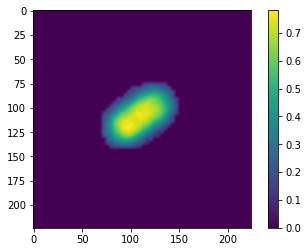

In [128]:
h = iter(dataloaders['7'])

data =  next(h)

input_img = data[0][0].unsqueeze(0)

print(f"class = {data[1]}")
input_img = input_img.to('cpu', dtype=torch.float)

plt.imshow(input_img[0].T[:,:,0])
plt.colorbar()

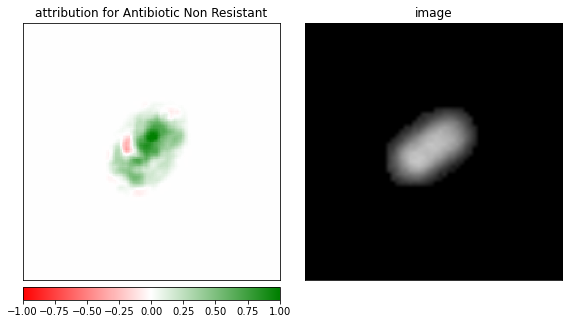

In [129]:
strides = (3, 3, 3)               # smaller = more fine-grained attribution but slower
target=1,                         # Antibiotic resistant
sliding_window_shapes=(3, 5, 5)  # choose size enough to change object appearance
baselines = 0                     # values to occlude the image with. 0 corresponds to gray

attribution_non_res = occlusion.attribute(input_img,
                                       strides = strides,
                                       target=target,
                                       sliding_window_shapes=sliding_window_shapes,
                                       baselines=baselines)

img = input_img[0].T.cpu().numpy()

attribution_non_res = np.transpose(attribution_non_res.squeeze().cpu().detach().numpy(), (1,2,0))

vis_types = ["heat_map", "original_image"]
vis_signs = ["all", "all"] # "positive", "negative", or "all" to show both
# positive attribution indicates that the presence of the area increases the prediction score
# negative attribution indicates distractor areas whose absence increases the score

_ = viz.visualize_image_attr_multiple(attribution_non_res,
                                      img,
                                      vis_types,
                                      vis_signs,
                                      ["attribution for Antibiotic Resistant", "image"],
                                      show_colorbar = True
                                     )

class = tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1])


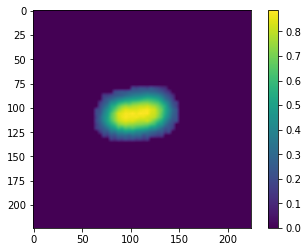

In [130]:
h = iter(dataloaders['7'])

data =  next(h)

input_img = data[0][0].unsqueeze(0)

print(f"class = {data[1]}")
input_img = input_img.to('cpu', dtype=torch.float)

plt.imshow(input_img[0].T[:,:,0])
plt.colorbar()

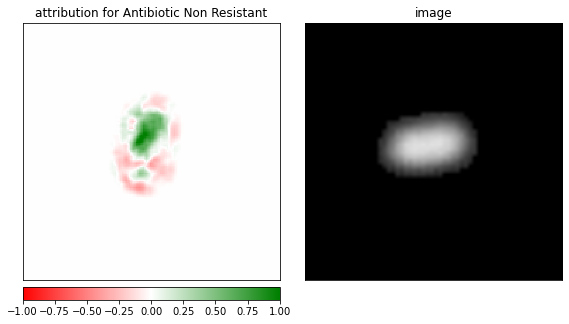

In [131]:
strides = (3, 3, 3)               # smaller = more fine-grained attribution but slower
target=1,                         # Antibiotic resistant
sliding_window_shapes=(3, 5, 5)  # choose size enough to change object appearance
baselines = 0                     # values to occlude the image with. 0 corresponds to gray

attribution_non_res = occlusion.attribute(input_img,
                                       strides = strides,
                                       target=target,
                                       sliding_window_shapes=sliding_window_shapes,
                                       baselines=baselines)

img = input_img[0].T.cpu().numpy()

attribution_non_res = np.transpose(attribution_non_res.squeeze().cpu().detach().numpy(), (1,2,0))

vis_types = ["heat_map", "original_image"]
vis_signs = ["all", "all"] # "positive", "negative", or "all" to show both
# positive attribution indicates that the presence of the area increases the prediction score
# negative attribution indicates distractor areas whose absence increases the score

_ = viz.visualize_image_attr_multiple(attribution_non_res,
                                      img,
                                      vis_types,
                                      vis_signs,
                                      ["attribution for Antibiotic Resistant", "image"],
                                      show_colorbar = True
                                     )

class = tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1])


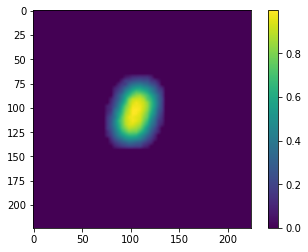

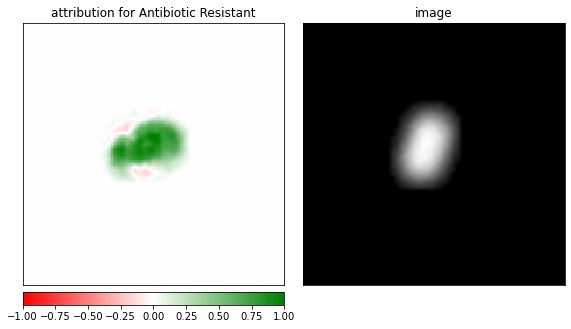

class = tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1])


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


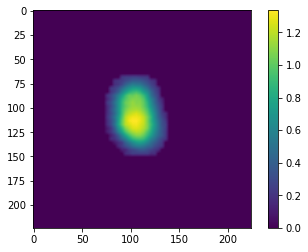

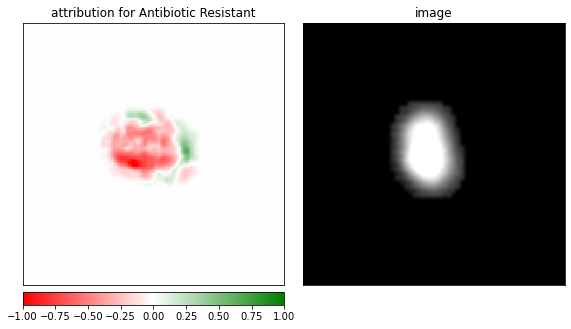

class = tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1])


In [ ]:
h = iter(dataloaders['7'])

for i in range(0,3):

    data =  next(h)

    input_img = data[0][0].unsqueeze(0)

    print(f"class = {data[1]}")
    input_img = input_img.to('cpu', dtype=torch.float)

    plt.imshow(input_img[0].T[:,:,0])
    plt.colorbar()
    
    strides = (3, 3, 3)               # smaller = more fine-grained attribution but slower
    target=1,                         # Antibiotic resistant
    sliding_window_shapes=(3, 5, 5)  # choose size enough to change object appearance
    baselines = 0                     # values to occlude the image with. 0 corresponds to gray

    attribution_non_res = occlusion.attribute(input_img,
                                           strides = strides,
                                           target=target,
                                           sliding_window_shapes=sliding_window_shapes,
                                           baselines=baselines)

    img = input_img[0].T.cpu().numpy()

    attribution_non_res = np.transpose(attribution_non_res.squeeze().cpu().detach().numpy(), (1,2,0))

    vis_types = ["heat_map", "original_image"]
    vis_signs = ["all", "all"] # "positive", "negative", or "all" to show both
    # positive attribution indicates that the presence of the area increases the prediction score
    # negative attribution indicates distractor areas whose absence increases the score

    _ = viz.visualize_image_attr_multiple(attribution_non_res,
                                          img,
                                          vis_types,
                                          vis_signs,
                                          ["attribution for Antibiotic Resistant", "image"],
                                          show_colorbar = True
                                         )